# <center> Practical work on Quantum dynamics and quantum control </center>
## <center> Lattice spin systems </center>
<center>Submitted by: Monika Das</center>

## Introduction to Lattice spin systems

The goal of this practical work is to study the lattice spin systems, which can be defined in terms of quantum spins and exchange integrals, $J$. For our purpose, we restrict our attention only on spin- $\frac{1}{2}$ systems.

A system of N spins is characterized by the Hilbert space $\mathcal{H} = (\mathbb{C}^2)^{\otimes N}$. The general Hamiltonian is written as,

$$
H = H_0 + H_{int},
$$

where, $H_0$ and $H_{int}$ are defined as follows,

$$
H_0 = \sum_{i=1}^N h_{0i},
$$
$$
H_{int} = -\sum_{i=1}^{N} \sum_{j>i} \vec{J}_{i j} \cdot \vec{S}_{i} \odot \vec{S}_{j}.
$$

The Hamiltonian of the $i$-th spin $h_{0i}$ is defined as,

$$
h_{0i} = \left(\begin{array}{cc}
-\omega & 0 \\
0 & 0
\end{array}\right),
$$

where, $\omega > 0$ is the Larmor precision frequency.

In the next section, we presented the python libraries and functions that have been used for this practical work. 

In [14]:
import numpy as np
from numpy import linalg as la
from scipy import linalg as LA2
import matplotlib.pyplot as plt
import random as rand
def opchain(a,i,nspin):
    if i==1:
      return LA2.kron(a,np.identity(2**(nspin-1)))
    else:
      if i==nspin:
        return LA2.kron(np.identity(2**(nspin-1)),a)
      else:
        return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
            
def opchain2(a,i,b,j,nspin):
        if i==1:
            if j==nspin:
                return LA2.kron(LA2.kron(a,np.identity(2**(nspin-2))),b)
            else:
                return LA2.kron(LA2.kron(a,np.identity(2**(j-2))),LA2.kron(b,np.identity(2**(nspin-j))))      
        else:
            if j==nspin:
                return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(nspin-(i+1))),b))
            else:
                return LA2.kron(LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))

def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)            
            
def diracrep(psi,nspin):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-6):
            state=state+'+'+str(psi[i])+'|'+format(i,'0'+str(nspin)+'b')+'>'
    return state

def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]

def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(tr)

def SvN(rho):
    vp=np.real(la.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def Disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)


## Hamiltonians and eigenstates of lattice spin systems
In this section, we will compute and study the eigenstates of lattice spin systems, particularly
the ground state and the first excited state. We will also compute and study the different properties of ground state.

In order to do so, we have considered several models. The first goal is to correctly compute the Hamiltonians of the models we have considered. Here we presented the function that will compute the Hamiltonian for most of our models.

In [4]:
def Hamiltonian(N, J, omega, close):
    S1 = 0.5*np.array([[0.,1.],[1.,0.]])
    S2 = 0.5*np.array([[0.,-1j],[1j,0.]])
    S3 = 0.5*np.array([[1.,0.],[0.,-1.]])
    S = (S1, S2, S3)
    H_0 = np.zeros((2**N, 2**N), dtype = 'complex')
    h0 = np.array([[-omega, 0.], [0., 0.]])
    H_int = np.zeros((2**N, 2**N), dtype = 'complex')
    for i in range (N):
        H_0 = H_0 + opchain(h0, i+1, N)
    for i in range (1,N):
        for u in range(3):
            H_int += - J[u] * opchain2(S[u],i,S[u],i+1,N)
    if close == 0: 
         #if rand == 0: return as usual
        return H_0 + H_int
         #if rand == 1: 
            
    elif close == 1:
        for u in range(3):
            H_int += - J[u] * opchain2(S[u],1,S[u],N,N)
        return H_0 + H_int 

## Case 1: Open Ising-Z spin chain
The Hamiltonian for open Ising-Z spin chain for different values of N is printed below.

In [8]:
omega = 0.5
J = np.array([0., 0., 1.])
N = 2
print("Hamiltonian for open Ising-Z spin chain for N=2:\n", Hamiltonian(N, J, omega, close = 0))

Hamiltonian for open Ising-Z spin chain for N=2:
 [[-1.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j]]


In [9]:
N = 3
print("Hamiltonian for open Ising-Z spin chain for N=3:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Ising-Z spin chain for N=3:
 [[-2. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j -1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j]]


In [10]:
N = 8
print("Hamiltonian for open Ising-Z spin chain for N=8:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Ising-Z spin chain for N=8:
 [[-5.75+0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -4.75+0.j  0.  +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j -4.25+0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 ...
 [ 0.  +0.j  0.  +0.j  0.  +0.j ... -1.25+0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ...  0.  +0.j -1.75+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j -1.75+0.j]]


## Case 2: Closed Ising-Z spin chain
In case of closed Ising-Z spin chain, an extra term will be added with the interaction Hamiltonian. Here, we print the total Hamiltonian for different values of N.

In [11]:
omega = 0.5
J = np.array([0., 0., 1.])
N = 3
print("Hamiltonian for closed Ising-Z spin chain for N=3:\n", Hamiltonian(N, J, omega, close=1))

Hamiltonian for closed Ising-Z spin chain for N=3:
 [[-2.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j -0.75+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j -0.75+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.75+0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.75+0.j]]


In [12]:
N = 8
print("Hamiltonian for closed Ising-Z spin chain for N=8:\n", Hamiltonian(N, J, omega, close=1))

Hamiltonian for closed Ising-Z spin chain for N=8:
 [[-6. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -4.5+0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -4.5+0.j ...  0. +0.j  0. +0.j  0. +0.j]
 ...
 [ 0. +0.j  0. +0.j  0. +0.j ... -1.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j -1.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j -2. +0.j]]


## Case 3: Open Ising-X spin chain
The Hamiltonian for open Ising-X spin chain for different values of N is printed below.

In [13]:
omega = 0.5
J = np.array([1., 0., 0.])
N = 2
print("Hamiltonian for open Ising-X spin chain for N=2:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Ising-X spin chain for N=2:
 [[-1.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j]
 [ 0.  +0.j -0.5 +0.j -0.25+0.j  0.  +0.j]
 [ 0.  +0.j -0.25+0.j -0.5 +0.j  0.  +0.j]
 [-0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]]


In [14]:
N = 3
print("Hamiltonian for open Ising-X spin chain for N=3:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Ising-X spin chain for N=3:
 [[-1.5 +0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j -0.25+0.j
   0.  +0.j]
 [ 0.  +0.j -1.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.25+0.j]
 [ 0.  +0.j -0.25+0.j -1.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [-0.25+0.j  0.  +0.j  0.  +0.j -0.5 +0.j  0.  +0.j -0.25+0.j  0.  +0.j
   0.  +0.j]
 [ 0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j -1.  +0.j  0.  +0.j  0.  +0.j
  -0.25+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j -0.5 +0.j -0.25+0.j
   0.  +0.j]
 [-0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j -0.5 +0.j
   0.  +0.j]
 [ 0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.  +0.j  0.  +0.j
   0.  +0.j]]


In [15]:
N = 8
print("Hamiltonian for open Ising-X spin chain for N=8:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Ising-X spin chain for N=8:
 [[-4.  +0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -3.5 +0.j -0.25+0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.25+0.j -3.5 +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 ...
 [ 0.  +0.j  0.  +0.j  0.  +0.j ... -0.5 +0.j -0.25+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ... -0.25+0.j -0.5 +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]]


## Case 4: Open Heisenberg XXX spin chain

In [16]:
omega = 0.5
J = np.array([1., 1., 1.])
N = 2
print("Hamiltonian for open Heisenberg XXX chain for N=2:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Heisenberg XXX chain for N=2:
 [[-1.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.25+0.j -0.5 +0.j  0.  +0.j]
 [ 0.  +0.j -0.5 +0.j -0.25+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j]]


In [17]:
N = 3
print("Hamiltonian for open Heisenberg XXX chain for N=3:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Heisenberg XXX chain for N=3:
 [[-2. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -1. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j -0.5+0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j -1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j]]


In [18]:
N = 8
print("Hamiltonian for open Heisenberg XXX chain for N=8:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Heisenberg XXX chain for N=8:
 [[-5.75+0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -4.75+0.j -0.5 +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.5 +0.j -4.25+0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
 ...
 [ 0.  +0.j  0.  +0.j  0.  +0.j ... -1.25+0.j -0.5 +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ... -0.5 +0.j -1.75+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j ...  0.  +0.j  0.  +0.j -1.75+0.j]]


## Case 5: Heisenberg-XYZ open spin chain:
In the case of Heisenberg open XYZ chain, we consider the following parameters,
No of spins = 8,
Larmor frequency, $\omega = 0.5$
and exchange integral, $\vec{J} = [0.5, 1., 1.5]$. The Hamiltonian is printed below:

In [19]:
omega = 0.5
J = np.array([0.5, 1., 1.5])
N = 8
print("Hamiltonian for open Heisenberg XYZ chain for N=8:\n", Hamiltonian(N, J, omega, close=0))

Hamiltonian for open Heisenberg XYZ chain for N=8:
 [[-6.625+0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j -5.375+0.j -0.375+0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j -0.375+0.j -4.625+0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 ...
 [ 0.   +0.j  0.   +0.j  0.   +0.j ... -1.625+0.j -0.375+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j ... -0.375+0.j -2.375+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  0.   +0.j -2.625+0.j]]


## Case 6: Random open Ising-X chain
In the case of random open Ising-X chain and spin glass, we built a new fundtion which we presented below.

In [59]:
def Hamiltonian_random_chain(N, J, omega):
    S1 = 0.5*np.array([[0.,1.],[1.,0.]])
    S2 = 0.5*np.array([[0.,-1j],[1j,0.]])
    S3 = 0.5*np.array([[1.,0.],[0.,-1.]])
    S = (S1, S2, S3)
    H_0 = np.zeros((2**N, 2**N), dtype = 'complex')
    H_int = np.zeros((2**N, 2**N), dtype = 'complex')
    for i in range (N):
        h0 = np.array([[-omega[i], 0.], [0., 0.]])
        H_0 = H_0 + opchain(h0, i+1, N)
    
    for i in range (1, N):
        for u in range(3):
            H_int += - J[u][i] * opchain2(S[u],i,S[u],i+1,N)
    return H_0 + H_int

In [62]:
N = 8
omega = np.zeros((N,))
J = (np.zeros((N,)), np.zeros((N,)), np.zeros((N,)))
for i in range(N):
    omega[i] = np.random.uniform(0., 0.5)
    J[0][i] = np.random.uniform(-1., 1.)
    
print("Hamiltonian for random open Ising X chain\n\n", Hamiltonian_random_chain(N, J, omega))

Hamiltonian for random open Ising X chain

 [[-2.52177595+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j -2.10933593+0.j  0.18059278+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.18059278+0.j -2.08549588+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... -0.43628008+0.j
   0.18059278+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.18059278+0.j
  -0.41244002+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]


## Case 7: Spin glass

In [63]:
N = 8
omega = np.zeros((N,))
### New definition of J
J = (np.zeros((N,)), np.zeros((N,)), np.zeros((N,)))
for i in range(N):
    omega[i] = np.random.uniform(0., 0.5)
    J[0][i] = np.random.uniform(-1., 1.)
    J[1][i] = np.random.uniform(-1., 1.)
    J[2][i] = np.random.uniform(-1., 1.)
print("Hamiltonian for spin glass\n\n", Hamiltonian_random_chain(N, J, omega))

Hamiltonian for spin glass

 [[-2.35914618+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j -1.87045624+0.j -0.10908017+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.10908017+0.j -2.06139062+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... -0.63949024+0.j
  -0.10908017+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... -0.10908017+0.j
  -0.28677289+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j -0.02363075+0.j]]


## The power method algorithm

There exists two families of algorithms to diagonalize matrices. One is the direct method that consists to compute the
root of the characteristic polynomial. Another is the iterative methods which are based on the matrix power method. We will restrict our focus on the power method. 

Let H be a Hermitian matrix with negative spectrum, Sp(H) = ( $\lambda_0, \lambda_1, .... , \lambda_{N-1}$ ). Let us also consider that $|{\psi}\rangle$ is a normalized state vector.

$$
|\psi\rangle = \sum_{i=0}^{N-1}|{\phi_i}\rangle
$$
in the basis {$|\phi_i\rangle$}.

Now, the power method algorithm can be expressed as,

$$
H^{k}|\psi\rangle=\sum_{i=0}^{N-1} c_{i} \lambda_{i}^{k}\left|\phi_{i}\right\rangle \simeq c_{0} \lambda_{0}^{k}\left|\phi_{0}\right\rangle \quad \text { if } k \text { is very large }
$$

since, being $ \left|\lambda_{0}\right| > \left|\lambda_{i}\right| ( \forall i>0 ), \lim _{k \rightarrow +\infty} \frac{\left|\lambda_{i}\right|^{k}}{\left|\lambda_{0}\right|^{k}} = 0 ( \forall i>0 ) $ . It follows that

$$
\lim _{k \rightarrow+\infty} \frac{H^{k}|\psi\rangle}{\| H^{k}|\psi\rangle \|}=\left|\phi_{0}\right\rangle .
$$

We can then find the ground state of $H$ by studying the sequence $ \left(\frac{H^{k}|\psi\rangle}{\| H^{k}|\psi\rangle \|}\right)_{k \in \mathbb{N}} $ . The ground level eigenvalue is found as $\lambda_{0}=\left\langle\phi_{0}|H| \phi_{0}\right\rangle$ with ground state $\left|\phi_{0}\right\rangle$ in the limit of the sequence.

To find the second eigenvector, we apply the same method but with a more special state $\left|\psi_{0}\right\rangle$ which has no component onto $\left|\phi_{0}\right\rangle$ but has components onto all other eigenstates. In practice $\left|\psi_{0}\right\rangle=\left(1-\left|\phi_{0}\right\rangle\left\langle\phi_{0}\right|\right)|\psi\rangle$. We have then

$$
\lim _{k \rightarrow+\infty} \frac{H^{k}\left|\psi_{0}\right\rangle}{\| H^{k}\left|\psi_{0}\right\rangle \|}=\left|\phi_{1}\right\rangle
$$

and so on for the other eigenvectors.

Here, we perent the code for power method algorithm to compute the ground state and first excited state.

In [36]:
def power_ground(H):            
### Parameters
    shift = 10
    epsilon = 1e-8
    kmax = 1e5
    k = 0
    phi_0 = np.random.rand(len(H), 1).astype(complex)
    phi_0 = phi_0/la.norm(phi_0)

### algorithm
    Id_N = np.identity(len(H))
    H = H - shift*Id_N
    phi_1 = np.matmul(H, phi_0)
    phi_0t = np.transpose(phi_0)
    temp = phi_1 - np.matmul(phi_0t, phi_1)*phi_0
    while la.norm(temp) > epsilon and k <= kmax:
        phi_0 = np.matmul(H, phi_0)
        phi_0 = phi_0/la.norm(phi_0)
        phi_1 = np.matmul(H, phi_0)
        temp = phi_1 - np.matmul(phi_0t, phi_1)*phi_0

        k = k + 1
    ### To see if the algorithm has converged or not, uncomment the following lines
    #if k == kmax:
      #  print('The algorithm has not converged')
    #else:
      #  print('The algorithm has converged')
        
    ## Compute the eigenvalue
    H = H + shift*Id_N
    phi_0t = np.transpose(phi_0)
    lambda_0 = np.matmul(phi_0t, np.matmul(H, phi_0))
    
    return phi_0, lambda_0

    

In [25]:
def power_excited(H, phi_0):
### Parameters
    shift = 10
    epsilon = 1e-8
    kmax = 1e5
    k = 0
    phi_1 = np.random.rand(len(H), 1).astype(complex)
## to project onto the orthogonal component of phi_0
    phi_1 = phi_1 - np.matmul(phi_0.T, phi_1)*phi_0
    phi_1 = phi_1/la.norm(phi_1)

### algorithm
    Id_N = np.identity(len(H))
    H = H - shift*Id_N
## compute temp with phi_1
    phi_2 = np.matmul(H, phi_1)
    phi_1t = np.transpose(phi_1)
    temp = phi_2 - np.matmul(phi_1t, phi_2)*phi_1
    while la.norm(temp) > epsilon and k <= kmax:
        phi_1 = np.matmul(H, phi_1)
        phi_1 = phi_1 - np.matmul(phi_0.T, phi_1)*phi_0
        phi_1 = phi_1/la.norm(phi_1)
    ## to compute temp
        phi_2 = np.matmul(H, phi_1)
        temp = phi_2 - np.matmul(phi_1t, phi_2)*phi_1
        k = k + 1
    ### Compute the eigen value    
    H = H + shift*Id_N
    phi_1t = np.transpose(phi_1)
    lambda_1 = np.matmul(phi_1t, np.matmul(H, phi_1))
        
    return phi_1, lambda_1

In order to study the different properties of the ground state, we first compute the ground state and first excited state for the case of open Ising-X spin chain. We then verified the obtained values with numpy functions. For both ground state and first excited state, our python function gave the good values that matched with numpy function (except a global phase factor for the first excited state). Therefore, we can safely say that our function is correct and we will use it for the next sections for further computations. 

In [31]:
#### Ground state & first excited state of model 3
N = 2
omega = 0.5
J = np.array([1., 0., 0.])
H_model3 = Hamiltonian(N, J, omega, close=0)
ground_state, eigen_ground = power_ground(H_model3) 
ground_dirac = diracrep(np.round(ground_state, decimals=2), nspin=2)    
print('ground state\n', ground_dirac)   
print('ground state eigen value:', eigen_ground)

#### First excited state
excited_state, eigen_excited = power_excited(H_model3, ground_state)  
excited_dirac = diracrep(np.round(excited_state, decimals=2), nspin=2)   
print('1st excited state\n', excited_dirac)   
print('1st excited state eigen value:', eigen_excited)

#### Check with numpy values
#### We used eigh function from the library la of numpy
#### eigh returns two objects, a 1-D array containing the eigenvalues of H, and 
### a 2-D square array or matrix of the corresponding eigenvectors (in columns).

#### To see the correspondng eigenvectors, print vector[:, i]
eigenvalue, vector = la.eigh(H_model3)
print('Numpy eigen value:\n',eigenvalue)
print('Numpy eigen vector ground state:\n',vector)

The algorithm has converged
ground state
 +[-0.97+0.j]|00>+[-0.23+0.j]|11>
ground state eigen value: [[-1.05901699+0.j]]
1st excited state
 +[-0.71+0.j]|01>+[-0.71+0.j]|10>
1st excited state eigen value: [[-0.75+0.j]]
Numpy eigen value:
 [-1.05901699 -0.75       -0.25        0.05901699]
Numpy eigen vector ground state:
 [[-0.97324899+0.j  0.        +0.j  0.        +0.j  0.22975292+0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j -0.70710678+0.j  0.        +0.j]
 [-0.22975292+0.j  0.        +0.j  0.        +0.j -0.97324899+0.j]]


## Properties of the ground state
### Para and ferromagnetic systems
In this section, we considered the models for three different systems, namely: 

1) Closed Ising-Z spin chain <br> 
2) Open Ising-X spin chain  <br>
3) Random open Ising-X spin chain <br> 

For these systems, we computed different properties like, the ground state, Von-Neumann entropy, entanglement and decoherence and plotted them to compare between different systems.

In [43]:
### Properties for model 2: Closed Ising-Z spin chain, for N=2
N = 2
omega = 0.5
J = np.array([0., 0., 1.])
H_model2 = Hamiltonian(N, J, omega, close=1)
ground_state2, eigen_ground = power_ground(H_model2) 
print('Properties for closed Ising-Z spin chain:\n')
print('ground state:\n', ground_state2)   
rho_av = avdensmat(ground_state2, N)  ### average density matrix
S_von = SvN(rho_av.reshape(2, 2))  ### VN entropy
print('Von-Neumann entropy:\n', S_von)
Entan = entangl(ground_state2.reshape(2**N,), 2)
print('Entanglement of the system:\n', Entan)
D = Disorder(ground_state2.reshape(2**N, ), 2)
print('Disorder of the system:\n', D)

### Properties for model 3: Open Ising-X spin chain, for N=2
N = 2
omega = 0.5
J = np.array([1., 0., 0.])
H_model3 = Hamiltonian(N, J, omega, close=0)
ground_state3, eigen_ground = power_ground(H_model3) 
print('Properties for open Ising-X spin chain:\n')
print('ground state:\n', ground_state3)   
rho_av = avdensmat(ground_state3, N)  ### average density matrix
S_von = SvN(rho_av.reshape(2, 2))  ### VN entropy
print('Von-Neumann entropy:\n', S_von)
Entan = entangl(ground_state3.reshape(2**N,), 2)
print('Entanglement of the system:\n', Entan)
D = Disorder(ground_state3.reshape(2**N, ), 2)
print('Disorder of the system:\n', D)

### Properties for model 6: random Open Ising-X spin chain, for N=8
N = 8
omega = np.zeros((N,))
J = (np.zeros((N,)), np.zeros((N,)), np.zeros((N,)))
for i in range(N):
    omega[i] = np.random.uniform(0., 0.5)
    J[0][i] = np.random.uniform(-1., 1.)
    
H_model6 = Hamiltonian_random_chain(N, J, omega)
ground_state6, eigen_ground = power_ground(H_model6) 
print('Properties for random open Ising-X spin chain:\n')
##print('ground state:\n', ground_state6)   
rho_av = avdensmat(ground_state6, N)  ### average density matrix
S_von = SvN(rho_av.reshape(2, 2))  ### VN entropy
print('Von-Neumann entropy:\n', S_von)
Entan = entangl(ground_state6.reshape(2**N,), N)
print('Entanglement of the system:\n', Entan)
D = Disorder(ground_state6.reshape(2**N, ), N)
print('Disorder of the system:\n', D)


Properties for closed Ising-Z spin chain:

ground state:
 [[-1.0e+000+0.j]
 [-1.5e-323+0.j]
 [-1.5e-323+0.j]
 [-2.5e-323+0.j]]
Von-Neumann entropy:
 -0.0
Entanglement of the system:
 -0.0
Disorder of the system:
 0.0
Properties for open Ising-X spin chain:

ground state:
 [[-9.73248989e-001+0.j]
 [-9.38724727e-323+0.j]
 [-9.38724727e-323+0.j]
 [-2.29752921e-001+0.j]]
Von-Neumann entropy:
 0.20663931388498374
Entanglement of the system:
 0.20663931388498374
Disorder of the system:
 0.0
Properties for random open Ising-X spin chain:

Von-Neumann entropy:
 0.4002877211498165
Entanglement of the system:
 0.37244448799237406
Disorder of the system:
 0.027843233157442415


The following python function aims to plot different properties of ground state.

In [69]:
def plot_prop(N, ground_state):
### Compute the population for both ground state and excited state, 
##look into the diagonal elements of the density matrix
    S_tot = np.zeros((N,))
    P_g = np.zeros((N,))
    P_e = np.zeros((N,))
    Coher = np.zeros((N,))
    for i in range(N):
        rho = np.real(densmat(ground_state, i+1, N))
        P_g[i] = rho[0, 0]   ### population of ground state
        P_e[i] = rho[1, 1]   ### population of excited state
        Coher[i] = np.abs(rho[0, 1])  ### coherence
        S_tot[i] = SvN(rho.reshape(2, 2))  ### Von-Neumann entropy
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(1, N, num=N), P_e, '-o', label='Population: excited state')
    plt.plot(np.linspace(1, N, num=N), P_g, '-o', label='Population: ground state')
    plt.plot(np.linspace(1, N, num=N), Coher, '-o', label='Coherence')
    plt.plot(np.linspace(1, N, num=N), S_tot, '-o', label='VN entropy')
    plt.xlabel('No of spins')
    plt.ylabel('Properties')
    plt.grid()
    plt.legend()
    
    return 

### Closed Ising Z spin chain
Here we plot the population, coherence and Von-Neumann entropy for closed Ising-Z spin chain.

Text(0.5, 1.0, 'Properties for closed Ising Z spin chain')

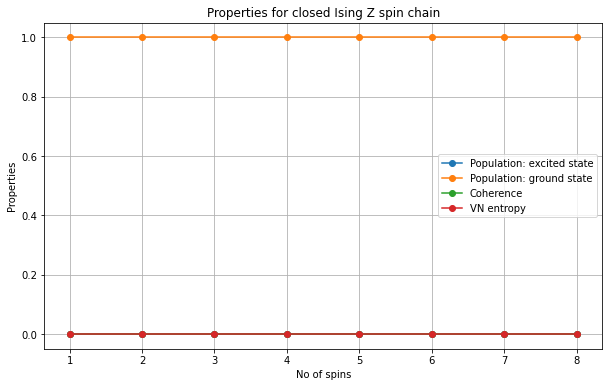

In [72]:
N2 = 8
omega = 0.5
J = np.array([0., 0., 1.])
H_model2 = Hamiltonian(N2, J, omega, close=1)
ground_state2, eigen_ground = power_ground(H_model2) 
plot_prop(N2, ground_state2)
plt.title('Properties for closed Ising Z spin chain')

### Open Ising X spin chain
Here we plot the population, coherence and Von-Neumann entropy for open Ising-X spin chain.

Text(0.5, 1.0, 'Properties for open Ising X spin chain')

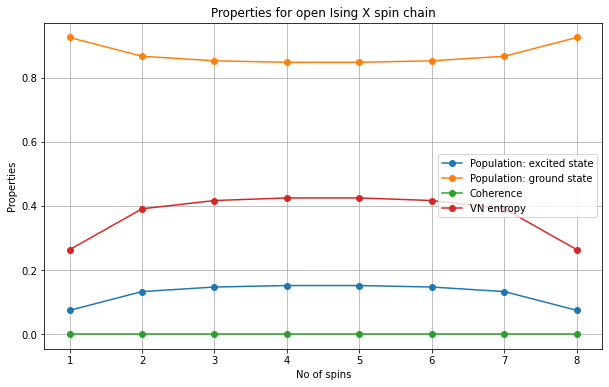

In [73]:
N3 = 8
omega = 0.5
J = np.array([1., 0., 0.])
H_model3 = Hamiltonian(N3, J, omega, close=0)
ground_state3, eigen_ground = power_ground(H_model3) 
plot_prop(N3, ground_state3)
plt.title('Properties for open Ising X spin chain')

### Random Open Ising X spin chain
Here we plot the population, coherence and Von-Neumann entropy for random open Ising-X spin chain.

Text(0.5, 1.0, 'Properties for random open Ising X spin chain')

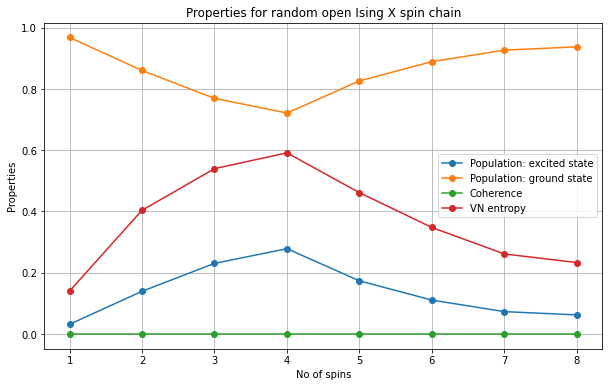

In [75]:
N = 8
plot_prop(N, ground_state6)
plt.title('Properties for random open Ising X spin chain')

### Comments on the properties

Ground state is the lowest energy state of a lattice spin system, which means all spins are aligned in the same direction, either up or down.

Now, looking into the properties of the ground state of a closed Ising Z spin chain, it is evident that the ground state is fully occupied and the population for excited state is zero. It is because we are working in the case of very low temerature. We also noticed that the coherence and Von Neumann entropy are zero in ground state.

The ground state properties of an open Ising X spin chain are similar to those of a closed Ising Z spin chain, but here we notice some major differences. In an open Ising X spin chain, the total spin is not conserved anymore and the system is no longer isolated. However, the population of ground state is still close to 1 and the population of excited state is close to zero and it changes with the change in number of spins. We also notice a zero coherence which means that there is no correlation between the spins, same as in the case of a closed Ising-Z chain. We also see a change in Von Neumann entropy with the change in number of spins. It is because with the increasing number of spins in the open Ising X spin chain, the number of possible states that the system can be in also increases, which leads to an increase in the entropy of the system, as there is more uncertainty in the state of the system. However, the Von Neumann entropy stabilizes as the number of spins is close to the maximun number of spin considered for our system, it means that the systems returns back to an ordered phase.

The noticeable property for a random open Ising-X chain is the excited state population, which is higher than in the case of a regular ising-X spin chain. The Von-Neumann entropy is as well higher than in the case of a regular Ising-X chain.

### Antiferromagnetic systems
In order to compare the ground state of a ferromagnetic system with that of an antiferromagnetic system, we computed and plotted the properties in two different plots in next sections. 

Text(0.5, 1.0, 'Ground state properties of a ferromagnetic Ising Z open chain')

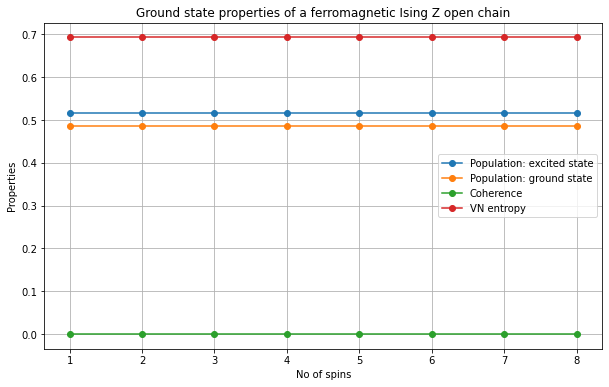

In [76]:
N = 8
omega = 0.
#### Ferromagnetic chain
J = np.array([0., 0., 1.])
H_ferro = Hamiltonian(N, J, omega, close=0)
ground_ferro, eigen_ground = power_ground(H_ferro) 
plot_prop(N, ground_ferro)
plt.title('Ground state properties of a ferromagnetic Ising Z open chain')

Text(0.5, 1.0, 'Ground state properties of a antiferromagnetic Ising Z open chain')

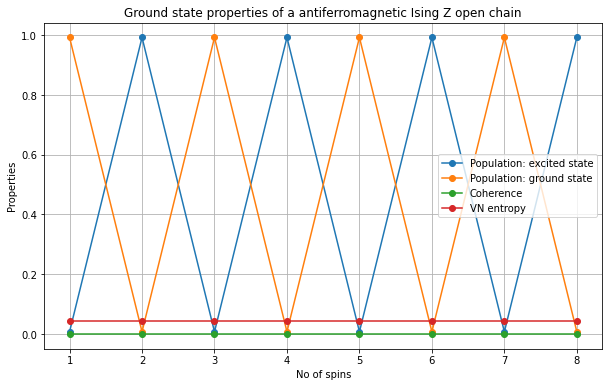

In [71]:
#### Anti-ferromagnetic chain
N = 8
omega = 0
J = np.array([0., 0., -1.])
H_antiferro = Hamiltonian(N, J, omega, close=0)
ground_antiferro, eigen_ground = power_ground(H_antiferro) 
plot_prop(N, ground_antiferro)
plt.title('Ground state properties of a antiferromagnetic Ising Z open chain')

### Comments on the plots

The ground state properties of a ferromagnetic Ising Z open chain and an anti-ferromagnetic Ising Z open chain are different due to the nature of the interactions between the spins. In a ferromagnetic Ising Z open chain, the interaction between the nearest neighbor spins is ferromagnetic, which means that the spins tend to align in the same direction, whereas, in an anti-ferromagnetic Ising Z open chain, the interaction between the nearest neighbor spins is anti-ferromagnetic, which means that the spins tend to align in opposite directions. The ground state of the later system is a state in which the spins are aligned in a checkerboard pattern, with spins on one sub-lattice pointing in one direction and spins on the other sub-lattice pointing in the opposite direction. 

Text(0.5, 1.0, 'Ground state properties of a ferromagnetic Ising Z closed chain')

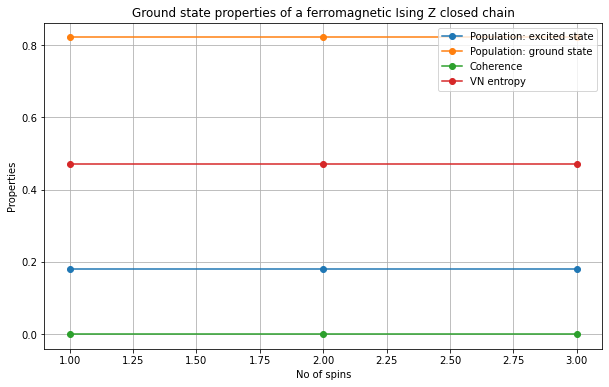

In [77]:
N = 3
omega = 0.
#### Ferromagnetic chain
J = np.array([0., 0., 1.])
H_ferro = Hamiltonian(N, J, omega, close=1)
ground_ferro, eigen_ground = power_ground(H_ferro) 
plot_prop(N, ground_ferro)
plt.title('Ground state properties of a ferromagnetic Ising Z closed chain')

Text(0.5, 1.0, 'Ground state properties of a ferromagnetic Ising Z closed chain')

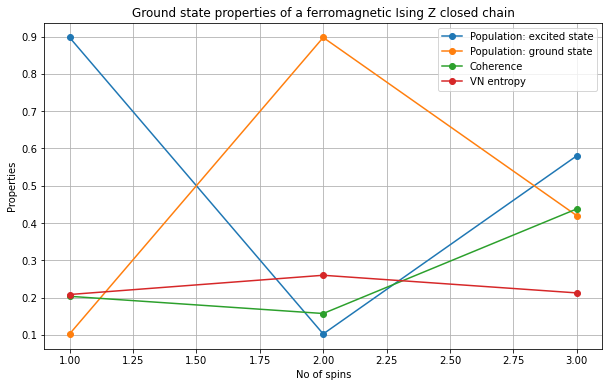

In [78]:
N = 3
omega = 0.
#### Ferromagnetic chain
J = np.array([0., 0., -1.])
H_antiferro = Hamiltonian(N, J, omega, close=1)
ground_antiferro, eigen_ground = power_ground(H_antiferro) 
plot_prop(N, ground_antiferro)
plt.title('Ground state properties of an anti-ferromagnetic Ising Z closed chain')

### Comments on the plots
The ground state properties of a ferromagnetic Ising Z closed chain and an anti-ferromagnetic Ising Z closed chain are different due to the nature of the interactions between the spins. In a ferromagnetic Ising Z closed chain, the interaction between the nearest neighbor spins is ferromagnetic, which means that the spins tend to align in the same direction, whereas, in an anti-ferromagnetic Ising Z closed chain, the interaction between the nearest neighbor spins is anti-ferromagnetic, which means that the spins tend to align in opposite directions. The ground state of the later system is a state in which the spins are aligned in a checkerboard pattern, with spins on one sub-lattice pointing in one direction and spins on the other sub-lattice pointing in the opposite direction.

## Dynamics of lattice spin systems
In this section we will study the quantum dynamics of a spin chain. The models we have considered are the following: <br> (1) Heisenberg-XXX open chain <br>
(2) Heisenberg-XXX closed chain <br>
(3) Inhomogenous Heisenberg-XXX open chain <br>
Let us first construct the Hamiltonians of the models mentioned above.

In [7]:
#### Model 1
omega = 1
J = np.array([0.1, 0.1, 0.1])
N = 7
print("Hamiltonian for Heisenberg XXX open chain for N=7:\n", np.real(Hamiltonian(N, J, omega, close=0)))

#### Model 2
omega = 1
J = np.array([0.1, 0.1, 0.1])
N = 7
print("Hamiltonian for Heisenberg XXX closed chain for N=7:\n", np.real(Hamiltonian(N, J, omega, close=1)))

Hamiltonian for Heisenberg XXX open chain for N=7:
 [[-7.15  0.    0.   ...  0.    0.    0.  ]
 [ 0.   -6.1  -0.05 ...  0.    0.    0.  ]
 [ 0.   -0.05 -6.05 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -1.05 -0.05  0.  ]
 [ 0.    0.    0.   ... -0.05 -1.1   0.  ]
 [ 0.    0.    0.   ...  0.    0.   -0.15]]
Hamiltonian for Heisenberg XXX closed chain for N=7:
 [[-7.175  0.     0.    ...  0.     0.     0.   ]
 [ 0.    -6.075 -0.05  ...  0.     0.     0.   ]
 [ 0.    -0.05  -6.075 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ... -1.075 -0.05   0.   ]
 [ 0.     0.     0.    ... -0.05  -1.075  0.   ]
 [ 0.     0.     0.    ...  0.     0.    -0.175]]


In [56]:
### Hamiltonian for Inhomogenous Heisenberg-XXX open chain
def H_inhomogeneous(N, J, omega):
    S1 = 0.5*np.array([[0.,1.],[1.,0.]])
    S2 = 0.5*np.array([[0.,-1j],[1j,0.]])
    S3 = 0.5*np.array([[1.,0.],[0.,-1.]])
    S = (S1, S2, S3)
    H_0 = np.zeros((2**N, 2**N), dtype = 'complex')
    h0 = np.array([[-omega, 0.], [0., 0.]])
    H_int = np.zeros((2**N, 2**N), dtype = 'complex')
    for i in range (N):
        H_0 = H_0 + opchain(h0, i+1, N)
    for i in range (1, N):
        for u in range(3):
            H_int += - J[u][i] * opchain2(S[u],i,S[u],i+1,N)
    return H_0 + H_int
#### Parameters
N = 7
omega = 1
J = (np.zeros((N,)), np.zeros((N,)), np.zeros((N,)))
for i in range(N):
    J[0][i] = 0.5/(i + 1)
    J[1][i] = 0.5/(i + 1)
    J[2][i] = 0.5/(i + 1)
H_inhom = np.real(H_inhomogeneous(N, J, omega)) 
print("Hamiltonian for inhomogeneous Heisenberg XXX open chain for N=7:\n", H_inhom)

Hamiltonian for inhomogeneous Heisenberg XXX open chain for N=7:
 [[-7.19910714  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -6.16339286 -0.03571429 ...  0.          0.
   0.        ]
 [ 0.         -0.03571429 -6.12172619 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -1.12172619 -0.03571429
   0.        ]
 [ 0.          0.          0.         ... -0.03571429 -1.16339286
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.19910714]]


In [52]:
#### Function to compute the time evolution
def Dyn(H, t, psi0):
    U_t = LA2.expm(-1j*H*t)
    psit = np.matmul(U_t, buildstate(psi0))
    return psit
#### plot the dynamics
def pop_plot(H, psi0):
    N = 7
    t = 500
    Ntime = 200
    nspin = N
    deltat = t/Ntime
    pop = np.zeros((nspin, Ntime))
##### Compute pop
    for i in range(Ntime):
### compute time evolution
        psi_t = Dyn(H, i*deltat, psi0)
        for k in range(nspin):
            pop[k, i] = np.real(densmat(psi_t, k+1, nspin))[1, 1]
#### density plot
    plt.figure(figsize=(10, 6))
    plt.contourf(range(1,nspin+1),[i*deltat for i in range(Ntime)],np.transpose(pop),[i*0.02 for i in range(51)],cmap='hot', antialiased=True)
    plt.xlabel('spins')
    plt.ylabel('time')
    plt.title("Density plot for initial condition: " + "|" + psi0 + ">")
    plt.colorbar()
    plt.show()
    return

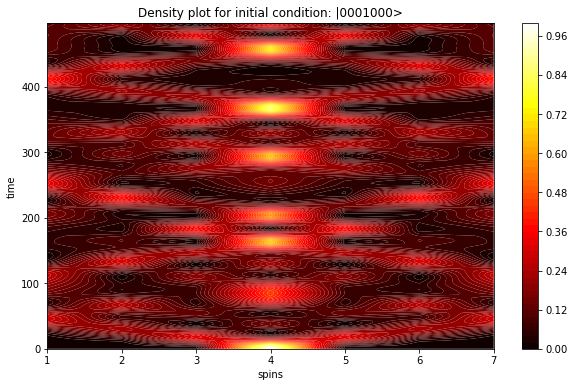

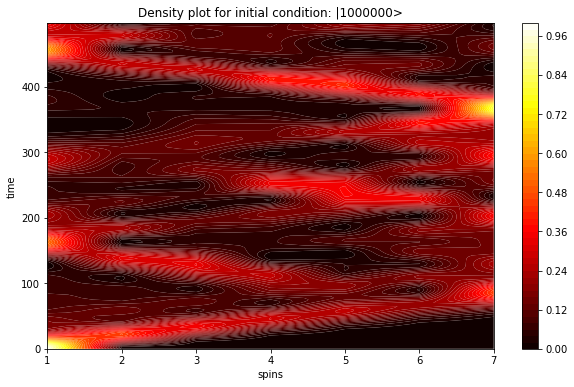

In [53]:
#### Model 1
print('Model: Heisenberg XXX open chain')
#### Initial condition psi0 = |0001000>
omega = 1
J = np.array([0.1, 0.1, 0.1])
N = 7
H = np.real(Hamiltonian(N, J, omega, close=0))
psi0 = '0001000'
pop_plot(H, psi0)
#### Initial condition psi0 = |1000000>
psi0 = '1000000'
pop_plot(H, psi0)

Model: Heisenberg XXX closed chain


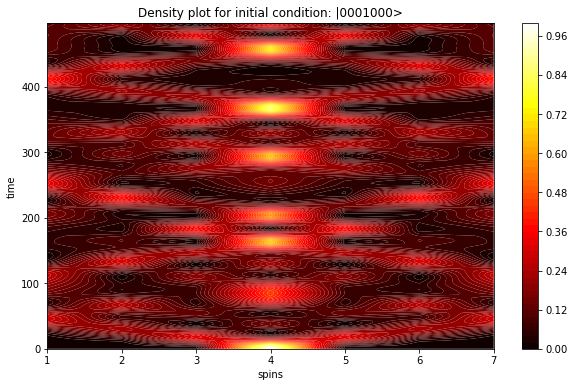

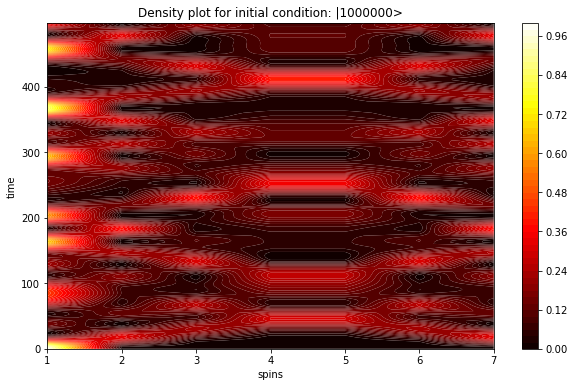

In [55]:
#### Model 2
print('Model: Heisenberg XXX closed chain')
#### Initial condition psi0 = |0001000>
omega = 1
J = np.array([0.1, 0.1, 0.1])
N = 7
H = np.real(Hamiltonian(N, J, omega, close=1))
psi0 = '0001000'
pop_plot(H, psi0)
#### Initial condition psi0 = |1000000>
psi0 = '1000000'
pop_plot(H, psi0)

Model: Inhomogeneous Heisenberg XXX open chain


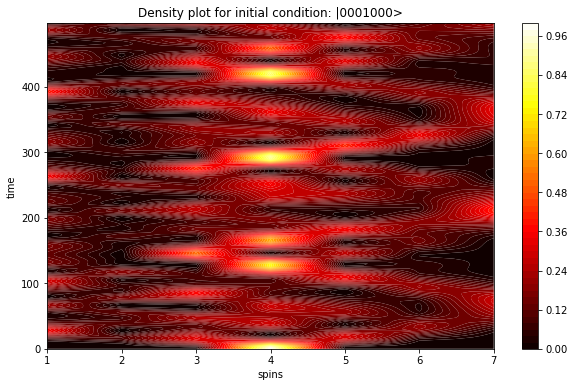

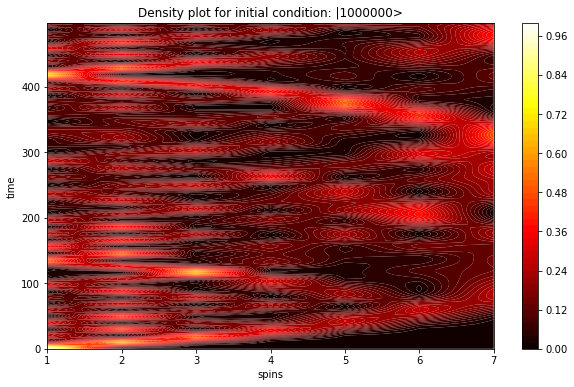

In [57]:
#### Model 3
print('Model: Inhomogeneous Heisenberg XXX open chain')
#### Initial condition psi0 = |0001000>
H = H_inhom
psi0 = '0001000'
pop_plot(H, psi0)
#### Initial condition psi0 = |1000000>
psi0 = '1000000'
pop_plot(H, psi0)

## Conclusion

In this practical work, we have studied different models for lattice spin systems using pyhton. We mostly constrained our focus to different models of spin-$\frac{1}{2}$ systems. As the important properties to study lies in the properties of ground states, therefore we aim to compute the ground state of the different systems. We studied different properties of the ground state like, the population, Von-Neumann entropy, coherence etc. Finally, we also made a density plot for the time evolution of some of our systems considering two specific initial states. 